In [903]:
import pandas as pd
import pandasql as sqldf
import numpy as np
import matplotlib as plt

**Step 1: Data Exploration and Data Cleaning**

Steps involved:

Identify null values

Identify and address irrelevant and duplicate data

Fix structural errors

Validate your data

**Step 2: Transformation and Analysis**

Filter out data outliers

Break data based on insights frim EDA. - *Only because we are fcosuing on faster data processing and not storage costs.*

Analysis based on grouping.

Analysis based on time (of day and time of cancellation and rejection).

*Statistical Analysis*
Mean, Median and Mode analysis.

Correlations

Normal Distributions Analysis.

**Step 3: Reporting/Visualization**

Average time to cancellation with and without driver, by the hour.

Distribution of average ETA by hours. 

**Step 4: Action items**

Identifying events with high frequency and investigate them. Identify the reason for outliers if any.


In [904]:
order = pd.read_csv("/Users/luppada/Documents/Projects/data/Gett/data_orders.csv")
offer = pd.read_csv("/Users/luppada/Documents/Projects/data/Gett/data_offers.csv")

Now we will explore more about the Orders dataset. 

**order_datetime** - time of the order

**origin_longitude** - longitude of the order

**origin_latitude** - latitude of the order

**m_order_eta** - time before order arrival

**order_gk** - order number

**order_status_key** - status, an enumeration consisting of the following mapping:
    4 - cancelled by client,
    9 - cancelled by system, i.e., a reject

**is_driver_assigned_key** - whether a driver has been assigned

**cancellation_time_in_seconds** - how many seconds passed before cancellation



In [905]:
def info(df):
    print(df.info())
    print("\n Shape of the dataframe above: ",df.shape,"\n")
    print(len(df['order_gk'].unique()),"orders are unique.\n")
    #print(""df.isna().sum())
order.pipe(info)
offer.pipe(info)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB
None

 Shape of the dataframe above:  (10716, 8) 

10716 orders are unique.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---

With preliminary data inspection we have identified that there are a few null values in the columns 'm_order_eta' and 'cancellations_time_in_seconds'. 

Based on the data description these nulls could be meaningful.

In [906]:

def nulls(df,a):
    
    Total_nulls = order[a].isna().sum()
    Nulls_client = order[a][order['order_status_key']==4].isna().sum()
    Nulls_system = order[a][order['order_status_key']==9].isna().sum()

    if Total_nulls == Nulls_client+Nulls_system:
        print("\nNulls in the" ,a, "column are relevant to the data.")
    else:
        print("\nNulls in the", a, "column exist for other reasons.")

print("Nulls in Orders data when cancelled by the client\n",order[order["order_status_key"]==4].isna().sum())
print("\nNulls in Orders data when cancelled by the System\n",order[order['order_status_key']==9].isna().sum())
colname = 'm_order_eta'

nulls(order,colname)

colname = 'cancellations_time_in_seconds'
nulls(order,colname)


Nulls in Orders data when cancelled by the client
 order_datetime                      0
origin_longitude                    0
origin_latitude                     0
m_order_eta                      4496
order_gk                            0
order_status_key                    0
is_driver_assigned_key              0
cancellations_time_in_seconds       0
dtype: int64

Nulls in Orders data when cancelled by the System
 order_datetime                      0
origin_longitude                    0
origin_latitude                     0
m_order_eta                      3406
order_gk                            0
order_status_key                    0
is_driver_assigned_key              0
cancellations_time_in_seconds    3409
dtype: int64

Nulls in the m_order_eta column are relevant to the data.

Nulls in the cancellations_time_in_seconds column are relevant to the data.


We will now break the order_datetime column into a new column that represents the hour of the day an order was setup. 

In [907]:
order['datetime'] = pd.to_datetime(order['order_datetime'])
order['datetime']=order['datetime'].dt.round("H").dt.hour
# Fill missing values in 'cancellations_time_in_seconds' with a default value, 0
order['cancellations_time_in_seconds'].fillna(0, inplace=True)
order['cancel_min']=(order['cancellations_time_in_seconds']/60).round(0).astype(int)
order['m_order_eta'].fillna(0, inplace=True)
order['eta_min']=(order['m_order_eta']/60).round(0).astype(int)

order

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,datetime,cancel_min,eta_min
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18,3,1
1,20:57:32,-0.950385,51.456843,0.0,3000583116437,4,0,128.0,21,2,0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,12,1,8
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,14,1,11
4,21:24:45,-0.967605,51.458236,0.0,3000583140877,9,0,0.0,21,0,0
...,...,...,...,...,...,...,...,...,...,...,...
10711,13:11:35,-0.975372,51.457846,0.0,3000599186906,4,0,36.0,13,1,0
10712,13:13:55,-0.975372,51.457846,0.0,3000599186962,4,0,4.0,13,0,0
10713,13:17:21,-0.972926,51.457693,60.0,3000599187034,4,1,34.0,13,1,1
10714,13:16:28,-0.975372,51.457846,0.0,3000599187024,4,0,6.0,13,0,0


The Offers data set is a simple map with 2 columns:

**order_gk** - order number, associated with the same column from the orders data set.

**offer_id** - ID of an offer


In [908]:
print(offer.head(),"\n")
offer.info()

if len(offer['offer_id'].unique()) == len(offer['offer_id']):
    print("\nEach offer is a unique offer, with size: ", len(offer['offer_id'].unique()))
else:
    print("\nFew offers are repeated. \nTotal unique values are: ", len(offer['offer_id'].unique()), "\nTotal values are: ", len(offer['offer_id']))

        order_gk      offer_id
0  3000579625629  300050936206
1  3000627306450  300052064651
2  3000632920686  300052408812
3  3000632771725  300052393030
4  3000583467642  300051001196 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB

Each offer is a unique offer, with size:  334363


We want to identify the uniqueness of the order_gk to identify there are any repeating values and common values with Orders dataset. We will also identify the uniqueness of the offer_id column before moving forward.

In [909]:
if len(offer['order_gk'].unique()) == len(offer['order_gk']):
    print("Each order is a unique order, with size: ", len(offer['order_gk'].unique()))
else:
    print("Few orders are repeated. \nTotal unique values are: ", len(offer['order_gk'].unique()), "\nTotal values are: ", len(offer['order_gk']))

Few orders are repeated. 
Total unique values are:  97967 
Total values are:  334363


In [910]:

if len(offer['offer_id'].unique()) == len(offer['offer_id']):
    print("Each offer is a unique offer, with size: ", len(offer['offer_id'].unique()))
else:
    print("Few offers are repeated. \nTotal unique values are: ", len(offer['offer_id'].unique()), "\nTotal values are: ", len(offer['offer_id']))

Each offer is a unique offer, with size:  334363


## Data Analysis - Exploratory DA and Statistical DA  

I will now start data analysis process. I will use statistical practices to identify outliers and observe the trends in data.

I will use correlation heatmaps, univariate analysis (normal distributions), bivariate analysis(boxplots, scatterplots).

<AxesSubplot:>

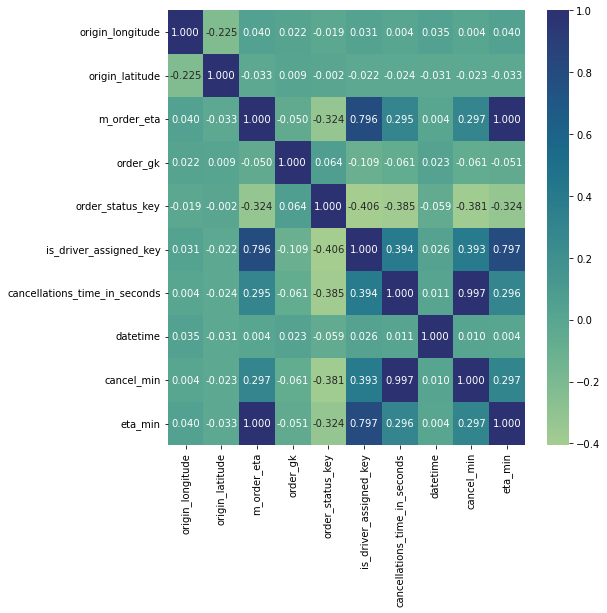

In [911]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
correlation = order.corr(method='pearson')
mask = correlation.isnull()
sns.heatmap(correlation, annot = True, cmap = 'crest',fmt=".3f",mask=mask)

<AxesSubplot:>

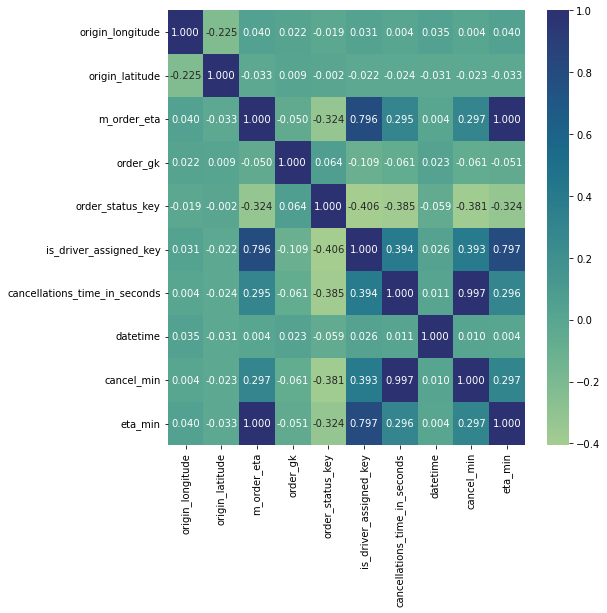

In [912]:
plt.figure(figsize=(8,8))
correlation = order.corr(method='pearson')
mask = correlation.isnull()
sns.heatmap(correlation, annot = True, cmap = 'crest',fmt=".3f",mask=mask)


The correlation analysis did not result in a significant correlation to investigate. We will now conduct univariate and bivariate analysis on various datapoints to take a deep into the data. The goal here is to identify outliers and regular datapoints.

C:\Users\luppada\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



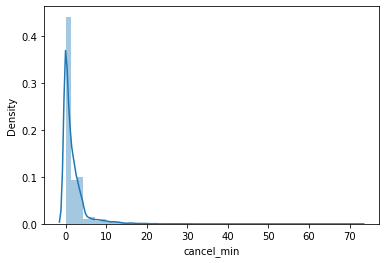

C:\Users\luppada\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



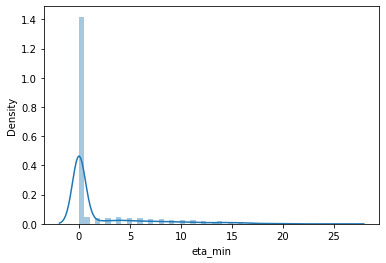

C:\Users\luppada\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



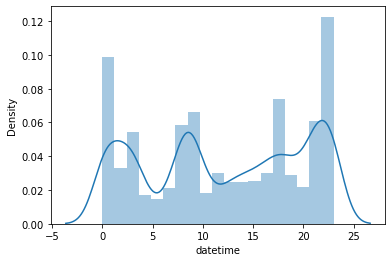

In [913]:
def normal(a):
    sns.distplot(a)
    plt.show()
#Normal distribution to understand the cancellation time metrics.
col=[order['cancel_min'],order['eta_min'],order['datetime']]
for i in col:
    normal(i)
    plt.show()


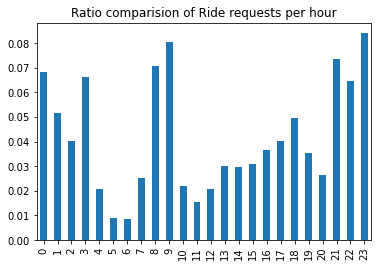

<Figure size 1080x864 with 0 Axes>

In [915]:
value_counts_normalized=order.datetime.value_counts(normalize=True)
sorted_value_counts = value_counts_normalized.sort_index(ascending=True)
sorted_value_counts.plot.bar()
plt.title("Ratio comparision of Ride requests per hour")
plt.figure(figsize=(15, 12))
plt.show()

***Bivariate analysis***

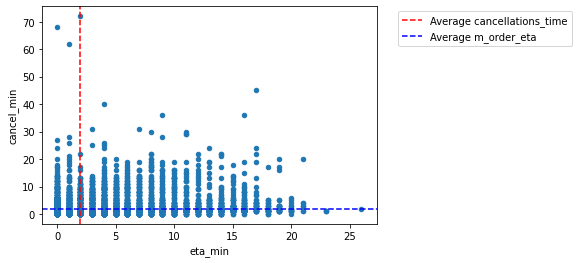

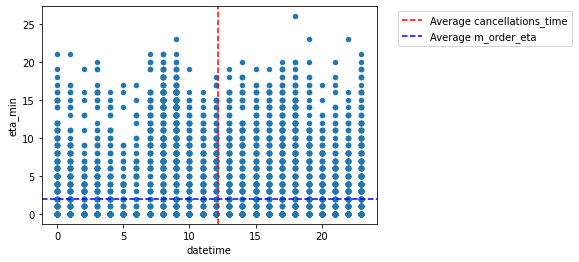

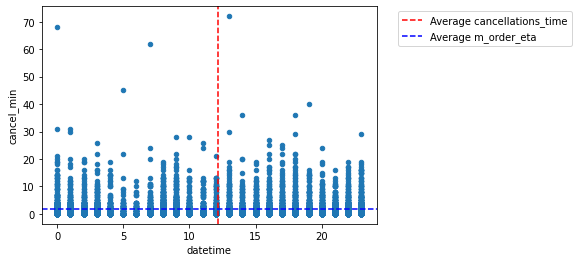

In [916]:
def scatter(a,b):
    var=a
    data = pd.concat([order[b],order[var]],axis=1)
    x_min, x_max = data[var].min(), data[var].max()
    y_min, y_max = data[b].min(), data[b].max()
    ax=data.plot.scatter(x=var,y=b,xlim=((x_min-(x_max-x_min)*0.05, ((x_max-x_min)*0.05+x_max))),ylim=((y_min-(y_max-y_min)*0.05, ((y_max-y_min)*0.05+y_max))))
    avg_x = data[a].mean()
    avg_y = data[b].mean()
    #median_x = data[a].median()
    #median_y = data[b].median()
# Adding average lines
    ax.axvline(x=avg_x, color='red', linestyle='--', label=f'Average cancellations_time')
    ax.axhline(y=avg_y, color='blue', linestyle='--', label='Average m_order_eta')
    # Display the legend
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    # Show the plot
    plt.show();
    
b,a='cancel_min','eta_min'
scatter(a,b)
d,c='eta_min','datetime'
scatter(c,d)
d,c='cancel_min','datetime'
scatter(c,d)


Based on the above plots we can see that most of the data is distributed around certain data points but there are also significant outliers that can skew the analysis. 

C:\Users\luppada\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



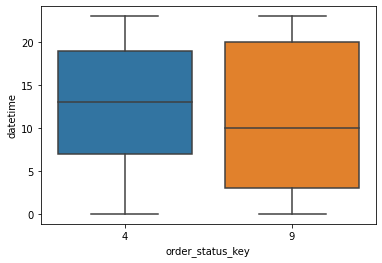

C:\Users\luppada\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



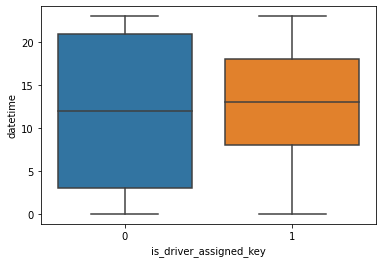

In [917]:
def box(a,b):
    sns.boxplot(order[a],order[b])
    plt.show()
    
box('order_status_key','datetime')
box('is_driver_assigned_key','datetime')

We can see that there are potential outliers that could have been caused due to one off situations. For this analysis we will consider that the outliers in ETA and cancellation times will be over 20 minutes. 

There are a significant number of "outliers" in hour vs ETA box plots.

---------

This could be becasue this dataset is a representation of both orders cancelled by clients and system.

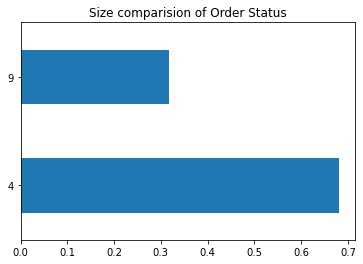

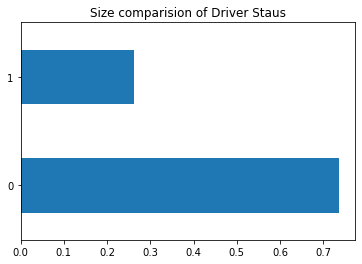

In [918]:
#Comparing 
order.order_status_key.value_counts(normalize=True).plot.barh()
plt.title("Size comparision of Order Status")
plt.show()
order.is_driver_assigned_key.value_counts(normalize=True).plot.barh()
plt.title("Size comparision of Driver Staus")
plt.show()

The charts above show the proportions of data of varied nature. This adds to the hypothesis that many outliers occur because order dataset is a representation of both orders cancelled by clients and system.

Next step is to identify the outliers and how significant they are. Before moving on to that part of the analysis, we will also analyze the offers dataset.

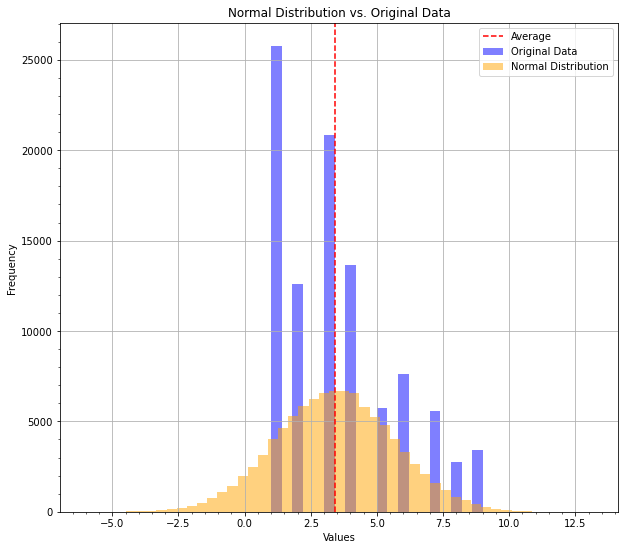

In [919]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
tot_sales=(offer['order_gk'].value_counts()).values

mu,std=np.mean(tot_sales), np.std(tot_sales)
distribution = np.random.normal(mu,std,len(tot_sales)) 
plt.figure(figsize=(10, 9))
med=np.median(tot_sales)
plt.axvline(x=mu, color='red', linestyle='--', label=f'Average')
#plt.axvline(x=med, color='red', linestyle='--', label=f'Median')

# Plot the original data
plt.hist(tot_sales, bins=20, alpha=0.5, label='Original Data', color='blue')

# Plot the normal distribution
plt.hist(distribution, bins=50, alpha=0.5, label='Normal Distribution', color='orange')
plt.minorticks_on()
#plt.xticks(np.arange(0, 10, step=1))
plt.title('Normal Distribution vs. Original Data')
plt.xlabel('Values')
#plt.yticks(distribution)
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

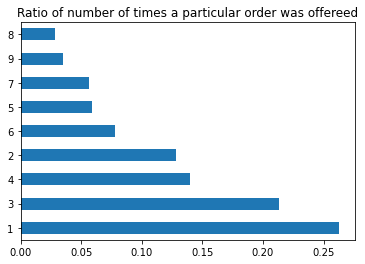

In [920]:
offer['order_gk'].value_counts().value_counts(normalize=True).plot.barh()
plt.title("Ratio of number of times a particular order was offereed")
plt.show()

We can see that only a little over the quarter offers sent out to drivers are accepted by drivers the first time, *assuming that the last occurance of a ride represents the ride acceptance and completion*. Almost **70%** the rides do not go through until that ride offered at least four times. Our goal now is to identify if there is a connection between type and time of cancelled, driver assignment status, time and ETAs. Before that we have to ensure that outliers are not in the data.

Our starting point would be the columns m_order_eta and cancellations_time_in_seconds.

In [921]:
print("Percentage  of orders with over 1200 seconds - 20 minutes ETA:\n",order['eta_min'][order['eta_min']>=20].size*100/order['eta_min'].size)
print("Percentage  of orders with ETA between 15 minutes and 20 minutes:\n",order['eta_min'][(order['eta_min']<=20) & (order['eta_min']>15)].size*100/order['m_order_eta'].size)
print("Percentage  of orders with under 60 seconds - 1 minute ETA:\n",order['eta_min'][order['eta_min']<=1].size*100/order['eta_min'].size)

Percentage  of orders with over 1200 seconds - 20 minutes ETA:
 0.23329600597237776
Percentage  of orders with ETA between 15 minutes and 20 minutes:
 1.8290406868234417
Percentage  of orders with under 60 seconds - 1 minute ETA:
 76.02650242627847


The rides with ETA over 20 minutes are 0.1% of the entire rides. Making them outliers, while we will separate them from further analysis, we will try to understand if there is a specific reason for this based on the location of these orders. 

In [922]:
import plotly.express as px

fig = px.scatter_mapbox(order[order['eta_min']>=20], lat='origin_latitude', lon='origin_longitude', color='m_order_eta',
                     #size='order_status_key',
                     title='Orders with ETA over 20 minutes')
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [923]:
import plotly.express as px

fig = px.scatter_mapbox(order[order['eta_min']<=1], lat='origin_latitude', lon='origin_longitude', color='m_order_eta',
                     #size='order_status_key',
                     title='Orders with ETA under 1 minute')
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [924]:
fig = px.scatter_mapbox(order[(order['eta_min']<=20)&(order['eta_min']>=10)], lat='origin_latitude', lon='origin_longitude', color='m_order_eta',
                     #size='order_status_key',
                     title='Orders with ETA over 10 minutes')
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [925]:
fig = px.scatter_mapbox(order[(order['eta_min']<=10)&(order['eta_min']>=1)], lat='origin_latitude', lon='origin_longitude', color='m_order_eta',
                     #size='order_status_key',
                     title='Orders with ETA under 10 minutes')
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Based on this spread of the order location we can say that the order outliers (orders with over ETA over 20 minutes) usually tend to happen in other regions where there are a significant number of orders with lower ETA. Hence we can remove them with out an issue for further analysis.

In [926]:
print("Checking for nulls in ETA after a driver is assigned")
if (order['eta_min'][order['is_driver_assigned_key']==1].isna().sum()) ==0:
    print("Nulls in ETA after driver is assigned is 0.")
else:
    print("Unaccounted ETA exists.")
    

if (order['eta_min'][order['is_driver_assigned_key']==0].isna().sum()) == order['m_order_eta'][order['is_driver_assigned_key']==0].size:
    print("Nulls in ETA after driver is not assigned is",order['m_order_eta'][order['is_driver_assigned_key']==0].size,".")
else:
          print("Unaccounted nulls exist.")


Checking for nulls in ETA after a driver is assigned
Nulls in ETA after driver is assigned is 0.
Unaccounted nulls exist.


The idea behind the code above is  that there should be no ETA after a driver is not assigned and there should be no nulls after a driver is assigned. 

------
In the next steps we will break down the data into two parts. One based on client cancellations and the other based on System cancellations for detailed analysis. 

The following columns will be dropped as  : 'order_status_key','cancellations_time_in_seconds','m_order_eta','is_driver_assigned_key'

In [927]:
dfClient = order[order['order_status_key']==4]
dfSystem = order[order['order_status_key']==9]

In [928]:
info(dfClient)
info(dfSystem)
info(order)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7307 entries, 0 to 10715
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 7307 non-null   object 
 1   origin_longitude               7307 non-null   float64
 2   origin_latitude                7307 non-null   float64
 3   m_order_eta                    7307 non-null   float64
 4   order_gk                       7307 non-null   int64  
 5   order_status_key               7307 non-null   int64  
 6   is_driver_assigned_key         7307 non-null   int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
 8   datetime                       7307 non-null   int64  
 9   cancel_min                     7307 non-null   int32  
 10  eta_min                        7307 non-null   int32  
dtypes: float64(4), int32(2), int64(4), object(1)
memory usage: 627.9+ KB
None

 Shape of the dataframe above:  

In [929]:
print(dfClient['is_driver_assigned_key'].value_counts(),"\n")
#print(dfClient['cancellations_time_in_seconds'].value_counts(),"\n")

print(dfSystem['is_driver_assigned_key'].value_counts(),"\n")
print(dfSystem['cancellations_time_in_seconds'].value_counts())
print(dfSystem['m_order_eta'].value_counts(),"\n")

0    4496
1    2811
Name: is_driver_assigned_key, dtype: int64 

0    3406
1       3
Name: is_driver_assigned_key, dtype: int64 

0.0    3409
Name: cancellations_time_in_seconds, dtype: int64
0.0      3406
418.0       1
60.0        1
298.0       1
Name: m_order_eta, dtype: int64 



There are three cancellations by system after a driver is assigned. Let's investigate this before we remove it.

In [930]:
outliers=dfSystem['order_gk'][dfSystem['is_driver_assigned_key']==1].values
#Find the outliers in the offers dataframe
for i in outliers:
    print("Order is offered",offer[offer['order_gk']==i].shape[0],"times.")
    print('\nFor', i,'\n--------------')
    print(order[['cancel_min','eta_min']][order['order_gk']==i],"\n")

Order is offered 0 times.

For 3000631256425 
--------------
      cancel_min  eta_min
1158           0        7 

Order is offered 1 times.

For 3000630156338 
--------------
      cancel_min  eta_min
6881           0        1 

Order is offered 3 times.

For 3000600112433 
--------------
      cancel_min  eta_min
7968           0        5 



Order 3000631256425, it was not offered to any driver. 
Order 3000630156338, it was offered to one driver.
Order 3000600112433, it was offered to one driver.
This could be a glitch that can be ignored as there is no significant frequency of this happening.
We can now move forward with dropping columns and start further analysis.

In [931]:
dfSystemNew=dfSystem[dfSystem['is_driver_assigned_key']!=1]

dfClient = dfClient.drop(['order_status_key','cancellations_time_in_seconds'],axis=1)
dfSystemNew = dfSystemNew.drop(['order_status_key','cancellations_time_in_seconds','m_order_eta','cancel_min','eta_min','is_driver_assigned_key'],axis=1)

In [932]:
info(dfClient)
info(dfSystem)
info(dfSystemNew)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7307 entries, 0 to 10715
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_datetime          7307 non-null   object 
 1   origin_longitude        7307 non-null   float64
 2   origin_latitude         7307 non-null   float64
 3   m_order_eta             7307 non-null   float64
 4   order_gk                7307 non-null   int64  
 5   is_driver_assigned_key  7307 non-null   int64  
 6   datetime                7307 non-null   int64  
 7   cancel_min              7307 non-null   int32  
 8   eta_min                 7307 non-null   int32  
dtypes: float64(3), int32(2), int64(3), object(1)
memory usage: 513.8+ KB
None

 Shape of the dataframe above:  (7307, 9) 

7307 orders are unique.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3409 entries, 4 to 10691
Data columns (total 11 columns):
 #   Column                         Non-Null Count  D

In [933]:
print((dfClient['cancel_min'][(dfClient['cancel_min']<20)&(dfClient['eta_min']<20)]).shape[0]/dfClient['cancel_min'].shape[0])
#print((dfClient['eta_min'][dfClient['eta_min']<=20]).shape[0]/dfClient.shape[0])
dfClientClean=dfClient[(dfClient['cancel_min']<20)&(dfClient['eta_min']<20)]
dfClientClean.describe()


0.9909675653482961


,origin_longitude,origin_latitude,m_order_eta,order_gk,is_driver_assigned_key,datetime,cancel_min,eta_min
count,7241.000000,7241.000000,7241.000000,7.241000e+03,7241.000000,7241.000000,7241.000000,7241.000000
mean,-0.964070,51.450594,164.607375,3.000597e+12,0.379644,12.455876,2.467201,2.757078
std,0.021634,0.011521,271.335396,2.433366e+07,0.485332,7.533059,2.858458,4.537470
min,-1.066952,51.399523,0.000000,3.000550e+12,0.000000,0.000000,0.000000,0.000000
25%,-0.973939,51.444823,0.000000,3.000583e+12,0.000000,7.000000,1.000000,0.000000
50%,-0.966688,51.452254,0.000000,3.000594e+12,0.000000,13.000000,2.000000,0.000000
75%,-0.949975,51.456706,239.000000,3.000623e+12,1.000000,19.000000,3.000000,4.000000
max,-0.867088,51.496169,1159.000000,3.000633e+12,1.000000,23.000000,19.000000,19.000000


In [934]:
dfSystemNew.describe()

,origin_longitude,origin_latitude,order_gk,datetime
count,3406.000000,3406.000000,3.406000e+03,3406.000000
mean,-0.964965,51.450500,3.000600e+12,11.478567
std,0.025197,0.012853,2.292027e+07,8.138340
min,-1.066957,51.399323,3.000550e+12,0.000000
25%,-0.975364,51.444256,3.000584e+12,3.000000
50%,-0.965421,51.451156,3.000596e+12,10.000000
75%,-0.948616,51.456830,3.000623e+12,20.000000
max,-0.872837,51.495445,3.000632e+12,23.000000


We will now break the client dataset into two parts based on whether a driver is assigned or not. Before this, we will convert the time to minutes.

In [935]:
#check for unique values of is_driver_assigned_key as a last step.
print(dfClientClean['is_driver_assigned_key'].unique())
#dfClient['cancel_min']=(dfClient['cancellations_time_in_seconds']/60).round(0).astype(int)

dfYes = dfClientClean[dfClientClean['is_driver_assigned_key']==1]
dfNo = dfClientClean[dfClientClean['is_driver_assigned_key']==0]

[1 0]


In [936]:
info(dfYes)
info(dfNo)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2749 entries, 0 to 10715
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_datetime          2749 non-null   object 
 1   origin_longitude        2749 non-null   float64
 2   origin_latitude         2749 non-null   float64
 3   m_order_eta             2749 non-null   float64
 4   order_gk                2749 non-null   int64  
 5   is_driver_assigned_key  2749 non-null   int64  
 6   datetime                2749 non-null   int64  
 7   cancel_min              2749 non-null   int32  
 8   eta_min                 2749 non-null   int32  
dtypes: float64(3), int32(2), int64(3), object(1)
memory usage: 193.3+ KB
None

 Shape of the dataframe above:  (2749, 9) 

2749 orders are unique.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4492 entries, 1 to 10714
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
-

We can now analyze for outliers and move forward with analysis.


In [937]:
dfYes = dfYes.drop(['is_driver_assigned_key'],axis=1) 
dfNo = dfNo.drop(['m_order_eta','is_driver_assigned_key'],axis=1)

In [938]:
dfYes.describe()

,origin_longitude,origin_latitude,m_order_eta,order_gk,datetime,cancel_min,eta_min
count,2749.000000,2749.000000,2749.000000,2.749000e+03,2749.000000,2749.000000,2749.000000
mean,-0.963189,51.450181,433.583849,3.000594e+12,12.503820,3.580939,7.262277
std,0.020104,0.011005,278.035581,2.543440e+07,6.743135,3.842100,4.638296
min,-1.060767,51.400069,60.000000,3.000550e+12,0.000000,0.000000,1.000000
25%,-0.973637,51.444823,232.000000,3.000579e+12,8.000000,1.000000,4.000000
50%,-0.966202,51.451806,359.000000,3.000592e+12,13.000000,2.000000,6.000000
75%,-0.949859,51.456173,599.000000,3.000623e+12,18.000000,5.000000,10.000000
max,-0.876492,51.494748,1159.000000,3.000633e+12,23.000000,19.000000,19.000000


In [939]:
dfNo.describe()

,origin_longitude,origin_latitude,order_gk,datetime,cancel_min,eta_min
count,4492.000000,4492.000000,4.492000e+03,4492.000000,4492.000000,4492.0
mean,-0.964609,51.450847,3.000599e+12,12.426536,1.785619,0.0
std,0.022504,0.011820,2.340245e+07,7.978578,1.707551,0.0
min,-1.066952,51.399523,3.000550e+12,0.000000,0.000000,0.0
25%,-0.974179,51.444828,3.000584e+12,4.000000,1.000000,0.0
50%,-0.966916,51.452490,3.000595e+12,13.000000,1.000000,0.0
75%,-0.950027,51.456839,3.000624e+12,21.000000,3.000000,0.0
max,-0.867088,51.496169,3.000632e+12,23.000000,18.000000,0.0


C:\Users\luppada\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



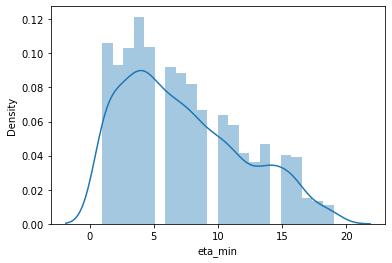

C:\Users\luppada\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



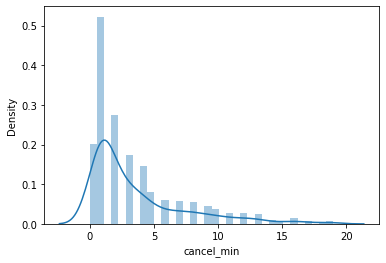

C:\Users\luppada\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



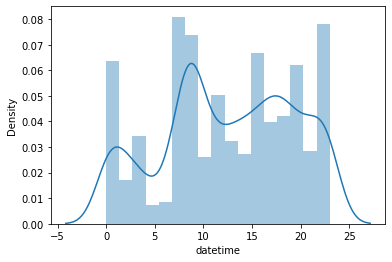

In [940]:
normal(dfYes['eta_min'])
normal(dfYes['cancel_min'])
normal(dfYes['datetime'])


C:\Users\luppada\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\luppada\Anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



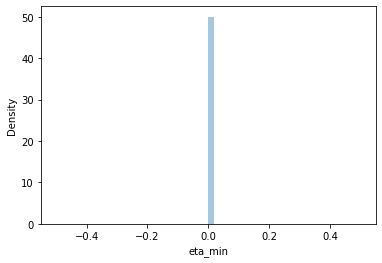

C:\Users\luppada\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



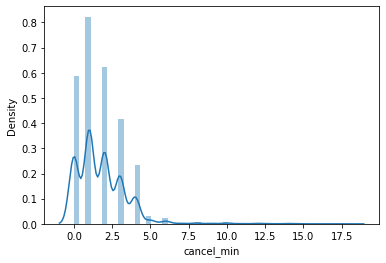

C:\Users\luppada\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



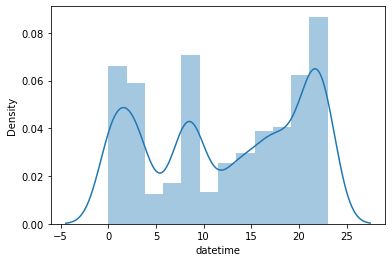

In [941]:
normal(dfNo['eta_min'])
normal(dfNo['cancel_min'])
normal(dfNo['datetime'])


Earlier we have identified that outliers in ETA and cancellation times should be over 1400 units and over 2000 units respectibely. We will now change both of these values to 1200 to eliminate more  

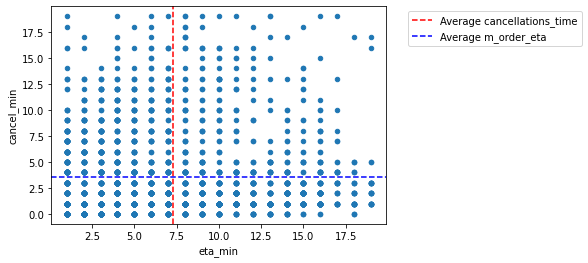

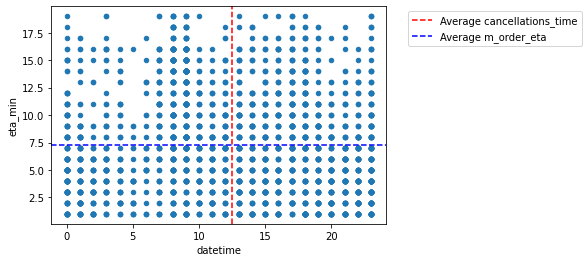

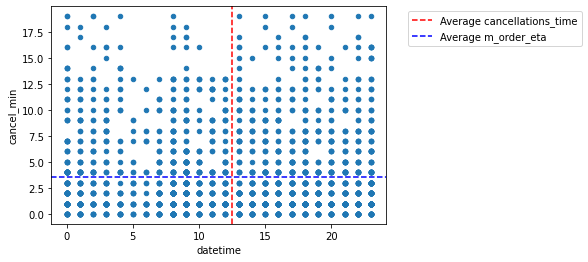

In [942]:
def scatter(a,b):
    var=a
    data = pd.concat([dfYes[b],dfYes[var]],axis=1)
    x_min, x_max = data[var].min(), data[var].max()
    y_min, y_max = data[b].min(), data[b].max()
    ax=data.plot.scatter(x=var,y=b,xlim=((x_min-(x_max-x_min)*0.05, ((x_max-x_min)*0.05+x_max))),ylim=((y_min-(y_max-y_min)*0.05, ((y_max-y_min)*0.05+y_max))))
    avg_x = data[a].mean()
    avg_y = data[b].mean()
    #median_x = data[a].median()
    #median_y = data[b].median()
# Adding average lines
    ax.axvline(x=avg_x, color='red', linestyle='--', label=f'Average cancellations_time')
    ax.axhline(y=avg_y, color='blue', linestyle='--', label='Average m_order_eta')
    # Display the legend
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    # Show the plot
    plt.show();
    
b,a='cancel_min','eta_min'
scatter(a,b)
d,c='eta_min','datetime'
scatter(c,d)
d,c='cancel_min','datetime'
scatter(c,d)


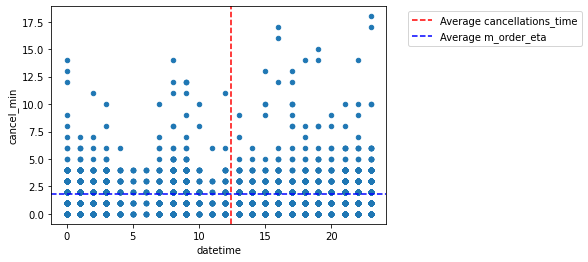

In [943]:
def scatter(a,b):
    var=a
    data = pd.concat([dfNo[b],dfNo[var]],axis=1)
    x_min, x_max = data[var].min(), data[var].max()
    y_min, y_max = data[b].min(), data[b].max()
    ax=data.plot.scatter(x=var,y=b,xlim=((x_min-(x_max-x_min)*0.05, ((x_max-x_min)*0.05+x_max))),ylim=((y_min-(y_max-y_min)*0.05, ((y_max-y_min)*0.05+y_max))))
    avg_x = data[a].mean()
    avg_y = data[b].mean()
    #median_x = data[a].median()
    #median_y = data[b].median()
# Adding average lines
    ax.axvline(x=avg_x, color='red', linestyle='--', label=f'Average cancellations_time')
    ax.axhline(y=avg_y, color='blue', linestyle='--', label='Average m_order_eta')
    # Display the legend
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    # Show the plot
    plt.show();
    
d,c='cancel_min','datetime'
scatter(c,d)


In [944]:
dfNo

,order_datetime,origin_longitude,origin_latitude,order_gk,datetime,cancel_min,eta_min
1,20:57:32,-0.950385,51.456843,3000583116437,21,2,0
9,06:33:52,-0.976216,51.433202,3000582765616,7,1,0
10,15:40:15,-0.934670,51.447065,3000582991062,16,3,0
11,20:59:35,-0.972735,51.452489,3000583116472,21,1,0
12,06:25:31,-0.958791,51.459481,3000582765488,6,1,0
...,...,...,...,...,...,...,...
10709,12:44:11,-0.975372,51.457846,3000597886155,13,1,0
10710,12:42:52,-0.975372,51.457846,3000597886140,13,1,0
10711,13:11:35,-0.975372,51.457846,3000599186906,13,1,0
10712,13:13:55,-0.975372,51.457846,3000599186962,13,0,0


In [945]:
time_bins = [0, 5, 10,15,float('inf')]  # Define your time intervals in seconds
labels = ['0-5 min', '5-10 min', '10-15 min', '15+ min']

# Create a new column with categorical data based on time intervals
dfNo['cancel_category'] = pd.cut(dfNo['cancel_min'], bins=time_bins, labels=labels, right=False)
dfYes['cancel_category'] = pd.cut(dfYes['cancel_min'], bins=time_bins, labels=labels, right=False)
dfNo['eta_category'] = pd.cut(dfNo['eta_min'], bins=time_bins, labels=labels, right=False)
dfYes['eta_category'] = pd.cut(dfYes['eta_min'], bins=time_bins, labels=labels, right=False)



In [946]:
# Assuming order is your DataFrame

# Use loc to set values based on the condition
dfYes.loc[(order['datetime'] < 6)&(order['datetime'] > 2), 'Time'] = 'Early Morning'
dfYes.loc[(order['datetime'] < 10)&(order['datetime'] >= 6), 'Time'] = 'Morning'
dfYes.loc[(order['datetime'] <= 14)&(order['datetime'] >= 10), 'Time'] = 'Lunch hour'
dfYes.loc[(order['datetime'] <= 19)&(order['datetime'] > 14), 'Time'] = 'Evening'
dfYes.loc[(order['datetime'] <= 21)&(order['datetime'] >= 19), 'Time'] = 'Night'
dfYes.loc[(order['datetime'] <= 2)|(order['datetime'] > 21), 'Time'] = 'Midnight'
# Display a few rows to verify the new column
print(dfYes[['datetime', 'Time']].head())

dfNo.loc[(order['datetime'] < 6)&(order['datetime'] > 2), 'Time'] = 'Early Morning'
dfNo.loc[(order['datetime'] < 10)&(order['datetime'] >= 6), 'Time'] = 'Morning'
dfNo.loc[(order['datetime'] <= 14)&(order['datetime'] >= 10), 'Time'] = 'Lunch hour'
dfNo.loc[(order['datetime'] <= 19)&(order['datetime'] > 14), 'Time'] = 'Evening'
dfNo.loc[(order['datetime'] <= 21)&(order['datetime'] >= 19), 'Time'] = 'Night'
dfNo.loc[(order['datetime'] <= 2)|(order['datetime'] > 21), 'Time'] = 'Midnight'
# Display a few rows to verify the new column
print(dfNo[['datetime', 'Time']].head())

dfSystemNew.loc[(order['datetime'] < 6)&(order['datetime'] > 2), 'Time'] = 'Early Morning'
dfSystemNew.loc[(order['datetime'] < 10)&(order['datetime'] >= 6), 'Time'] = 'Morning'
dfSystemNew.loc[(order['datetime'] <= 14)&(order['datetime'] >= 10), 'Time'] = 'Lunch hour'
dfSystemNew.loc[(order['datetime'] <= 19)&(order['datetime'] > 14), 'Time'] = 'Evening'
dfSystemNew.loc[(order['datetime'] <= 21)&(order['datetime'] >= 19), 'Time'] = 'Night'
dfSystemNew.loc[(order['datetime'] <= 2)|(order['datetime'] > 21), 'Time'] = 'Midnight'
# Display a few rows to verify the new column
print(dfSystemNew[['datetime', 'Time']].head())


    datetime        Time
0         18     Evening
2         12  Lunch hour
3         14  Lunch hour
13        17     Evening
14         1    Midnight
    datetime     Time
1         21    Night
9          7  Morning
10        16  Evening
11        21    Night
12         6  Morning
   datetime     Time
4        21    Night
5        21    Night
6         8  Morning
7         8  Morning
8         9  Morning


In [947]:
eta_Y=dfYes.groupby('eta_category')['eta_category'].count().to_dict()
cancel_Y=dfYes.groupby('cancel_category')['cancel_category'].count().to_dict()
hour_Y=dfYes.groupby('Time')['Time'].count().to_dict()
hour_Y = collections.OrderedDict(sorted(hour_Y.items(), key=lambda x: (
    ['Midnight', 'Early Morning', 'Morning', 'Lunch hour', 'Evening', 'Night'].index(x[0]))
))
eta_N=dfNo.groupby('eta_category')['eta_category'].count().to_dict()
cancel_N=dfNo.groupby('cancel_category')['cancel_category'].count().to_dict()
hour_N=dfNo.groupby('Time')['Time'].count().to_dict()
hour_N = collections.OrderedDict(sorted(hour_N.items(), key=lambda x: (
    ['Midnight', 'Early Morning', 'Morning', 'Lunch hour', 'Evening', 'Night'].index(x[0]))
))

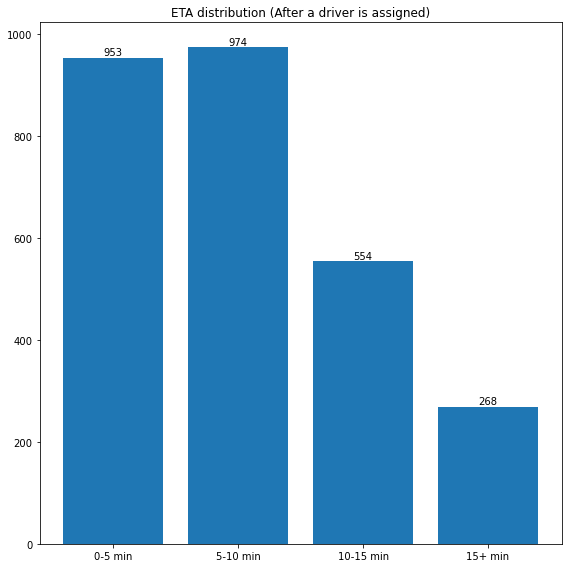

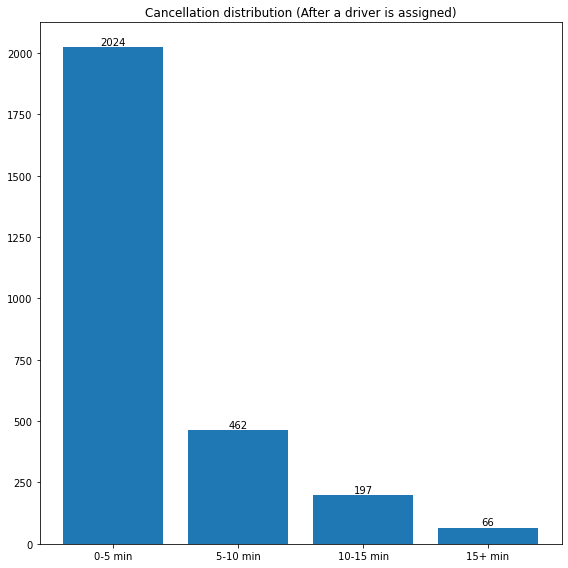

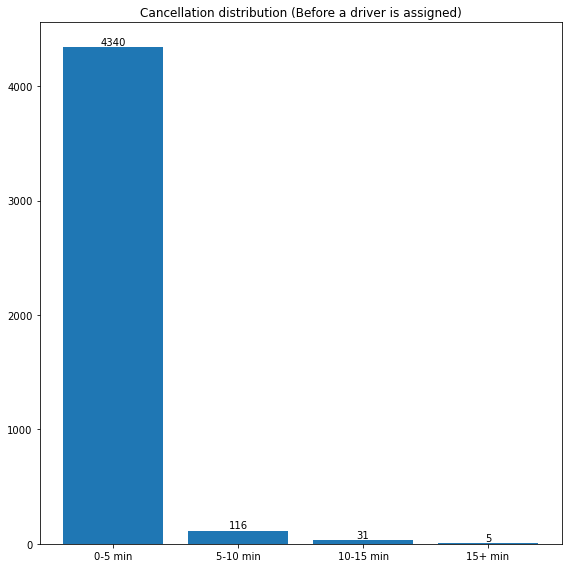

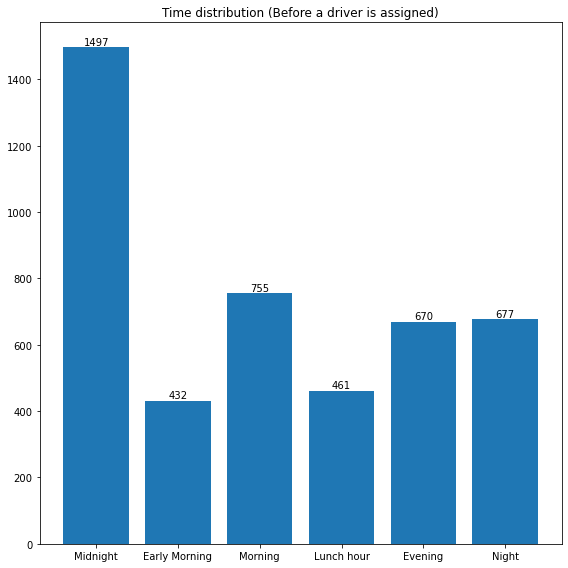

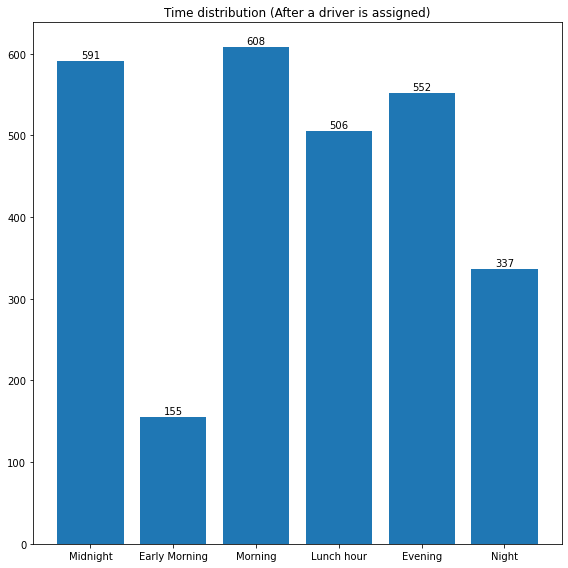

In [948]:

def timedis(a,b):
    lis = [i for i in list(a.values())]
    sizes = lis
    labels = a.keys()
    plt.figure(figsize=(8, 8))
    bars=plt.bar(labels, sizes)
#plt.xlabel('DataFrames')
#plt.ylabel('Sizes')

    plt.title(b)
    for bar, size in zip(bars, sizes):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, size, ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    
timedis(eta_Y,'ETA distribution (After a driver is assigned)')
timedis(cancel_Y,'Cancellation distribution (After a driver is assigned)')
#timedis(eta_N,'ETA distribution (Before a driver is assigned)')
timedis(cancel_N,'Cancellation distribution (Before a driver is assigned)')
timedis(hour_N,'Time distribution (Before a driver is assigned)')
timedis(hour_Y,'Time distribution (After a driver is assigned)')

In [949]:
eta_Y

{'0-5 min': 953, '5-10 min': 974, '10-15 min': 554, '15+ min': 268}

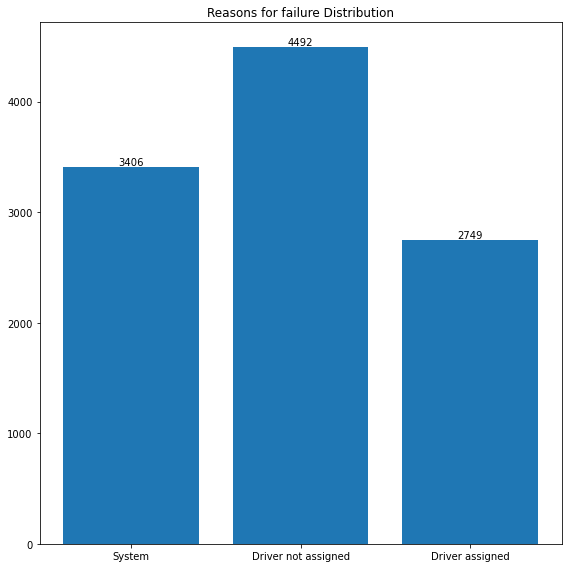

In [950]:
labels = ['System','Driver not assigned','Driver assigned']
sizes = [dfSystemNew.shape[0],dfNo.shape[0],dfYes.shape[0]]
plt.figure(figsize=(8, 8))
bars=plt.bar(labels, sizes)
#plt.xlabel('DataFrames')
#plt.ylabel('Sizes')

plt.title('Reasons for failure Distribution')
for bar, size in zip(bars, sizes):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, size, ha='center', va='bottom')

plt.tight_layout()
plt.show()

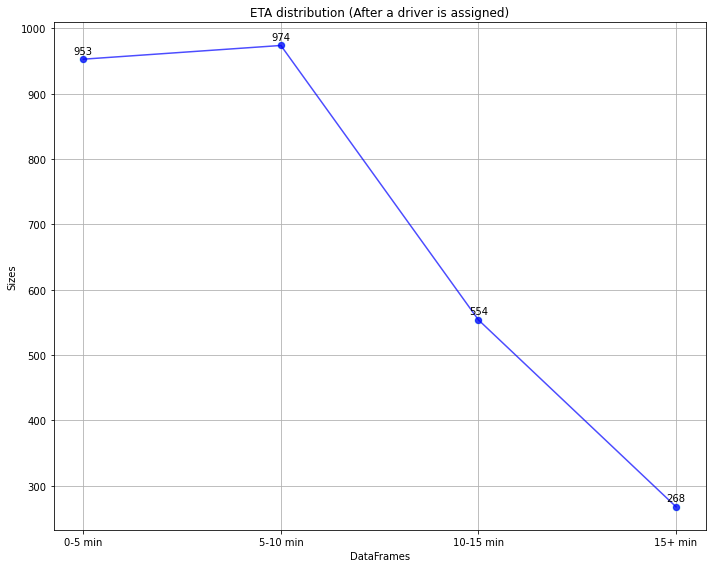

In [951]:
def timedis(a, b):
    labels = list(a.keys())
    sizes = list(a.values())

    plt.figure(figsize=(10, 8))
    
    # Convert to scatter plot
    dot=plt.scatter(labels, sizes, s=50, color='skyblue', alpha=0.7)
    plt.plot(labels, sizes,  color='blue', alpha=0.7, linestyle='-', marker='o')  # Adjust linestyle and marker as needed
    
    plt.title(b)
    for label, size in zip(labels, sizes):
        plt.text( label, size, str(size), ha='center', va='bottom',position=(label,size+5))
        
    plt.xlabel('DataFrames')
    plt.ylabel('Sizes')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
timedis(eta_Y,'ETA distribution (After a driver is assigned)')


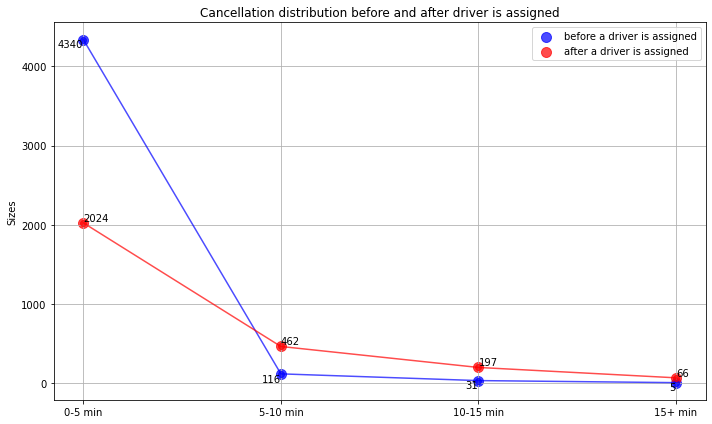

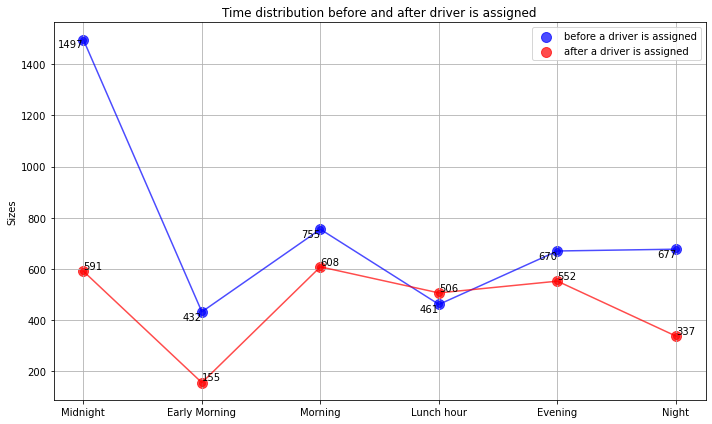

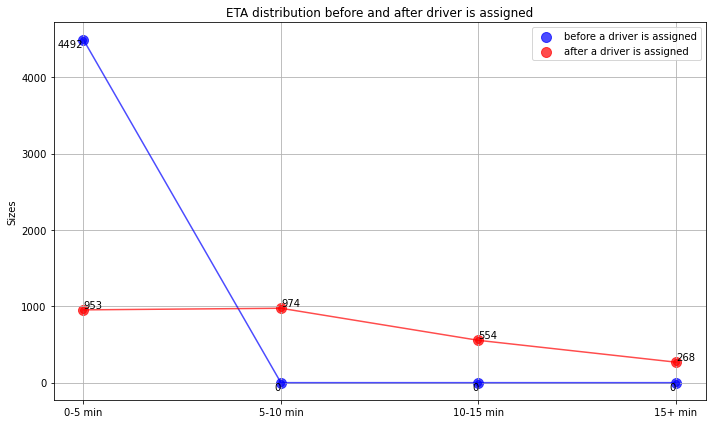

In [952]:
def scattertime(a, b, c, d,e):
    labels_a = list(a.keys())
    sizes_a = list(a.values())
    
    labels_c = list(c.keys())
    sizes_c = list(c.values())

    plt.figure(figsize=(10, 6))
    
    # Scatter plot for the first dictionary
    plt.scatter(labels_a, sizes_a, s=100, color='blue', alpha=0.7, label=b+'a driver is assigned')
    plt.plot(labels_a, sizes_a,  color='blue', alpha=0.7, linestyle='-', marker='o')  # Adjust linestyle and marker as needed

    # Scatter plot for the second dictionary
    plt.scatter(labels_c, sizes_c, s=100, color='red', alpha=0.7, label=d+'a driver is assigned')
    plt.plot(labels_c, sizes_c,  color='red', alpha=0.7, linestyle='-', marker='o')  # Adjust linestyle and marker as needed
    plt.title(e + b + 'and ' + d+'driver is assigned')
    for label, size in zip(labels_a, sizes_a):
        plt.text(label, size, str(size),ha='right', va='top',position=(label,size+0.5))
    for label, size in zip(labels_c, sizes_c):
        plt.text(label, size, str(size),ha='left', va='bottom',position=(label,size+0.5))
 
    plt.ylabel('Sizes')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

scattertime(cancel_N,'before ',cancel_Y,'after ','Cancellation distribution ')
#timedis(eta_N,'ETA distribution (Before a driver is assigned)')

scattertime(hour_N,'before ',hour_Y,'after ',"Time distribution ")
scattertime(eta_N,'before ',eta_Y,'after ','ETA distribution ')

In [953]:
import collections
avg=dfYes.groupby('Time')['eta_min'].mean().to_dict()
sorted_avg = collections.OrderedDict(sorted(avg.items(), key=lambda x: (
    ['Midnight', 'Early Morning', 'Morning', 'Lunch hour', 'Evening', 'Night'].index(x[0]))
))
rounded_avg = {key: round(value, 2) for key, value in sorted_avg.items()}
rounded_avg

{'Midnight': 5.92,
 'Early Morning': 6.26,
 'Morning': 9.73,
 'Lunch hour': 6.81,
 'Evening': 7.62,
 'Night': 5.71}

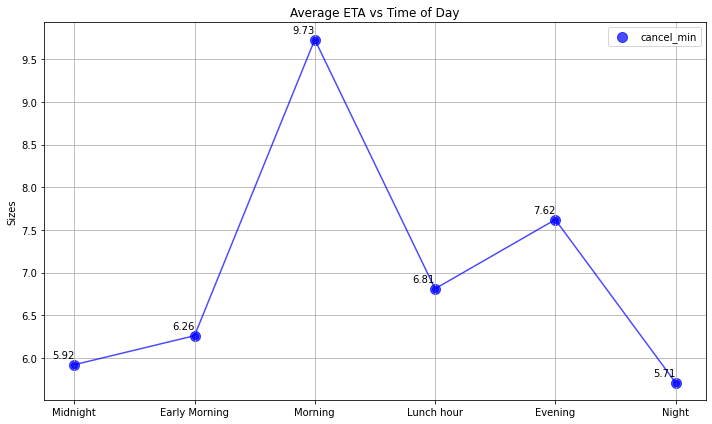

In [954]:

labels_a = list(rounded_avg.keys())
sizes_a = list(rounded_avg.values())
plt.figure(figsize=(10, 6))
    
    # Scatter plot for the first dictionary
plt.scatter(labels_a, sizes_a, s=100, color='blue', alpha=0.7, label=b)
plt.plot(labels_a, sizes_a,  color='blue', alpha=0.7, linestyle='-', marker='o')  # Adjust linestyle and marker as needed
plt.title('Average ETA vs Time of Day')
plt.ylabel('Sizes')
for label, size in zip(labels_a, sizes_a):
        plt.text(label, size, str(size),ha='right', va='bottom',position=(label,size+0.05))
    
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Because I have completed all given tasks, I will now dive into further analysis. 

import pandas as pd
from geopy.geocoders import Nominatim
import geocoder

def geo_rev(x):
    g = geocoder.osm([x.origin_latitude, x.origin_longitude], method='reverse').json
    #a =g.json
    if g:
        return g.get('suburb')
    else:
        return 'no country'

#dfSystem=dfSystem[['origin_latitude', 'origin_longitude']].apply(geo_rev, axis=1)

order.rename(columns={'city':'Area'},inplace =True)


unique_data = order.groupby('Area').agg({'origin_longitude': 'unique', 'origin_latitude': 'unique'}).reset_index()
unique_data['origin_latitude'] = unique_data['origin_latitude'].apply(lambda x: x[0])
unique_data['origin_longitude'] = unique_data['origin_longitude'].apply(lambda x: x[0])


def geo_rev(x):
    g = geocoder.osm([x.origin_latitude, x.origin_longitude], method='reverse').json
    #a =g.json
    if g:
        return  g.get('town')or g.get('county') or g.get('town')or 'Unknown'
    else:
        return 'no country'

unique_data['town']=unique_data[['origin_latitude', 'origin_longitude']].apply(geo_rev, axis=1)
#unique_data.to_csv('/Users/luppada/Documents/Projects/data/Gett/areas.csv',index=False)
#order.to_csv('/Users/luppada/Documents/Projects/data/Gett/areas.csv',index=False)


The two blocks of code above were used to pull geographical data using longitude and latitude values from the original orders data. As it takes too long to process (took me overnight on my system), I have saved them as markdowns. I have saved the area and town location dataframe as a csv file on my computer and will be using it to pull that georgraphical data. 

In [955]:
order = pd.read_csv("/Users/luppada/Documents/Projects/data/Gett/order.csv")


In [957]:
dfYes=pd.merge(dfYes,order[['order_gk','town','Area']],on='order_gk',how='inner')
dfNo=pd.merge(dfNo,order[['order_gk','town','Area']],on='order_gk',how='inner')
dfSystemNew=pd.merge(dfSystemNew,order[['order_gk','town','Area']],on='order_gk',how='inner')


In [958]:
print("Areas where cancellations are observed \n")
print('Overall: Total suburbs',len(order['Area'].unique()),' and Cites/Towns',len(order['town'].unique()))
print('After a driver is assigned: Total suburbs',len(dfYes['Area'].unique()),'and Cites/Towns',len(dfYes['town'].unique()))
print('Before a driver is assigned: Total suburbs',len(dfNo['Area'].unique()),' and Cites/Towns',len(dfNo['town'].unique()))
print('Cancelled by system:Total suburbs',len(dfSystemNew['Area'].unique()),' and Cites/Towns',len(dfSystemNew['town'].unique()))
print('\nCities/Towns serviced by Gett:\n',order['town'].unique())

Areas where cancellations are observed 

Overall: Total suburbs 32  and Cites/Towns 5
After a driver is assigned: Total suburbs 26 and Cites/Towns 4
Before a driver is assigned: Total suburbs 31  and Cites/Towns 5
Cancelled by system:Total suburbs 31  and Cites/Towns 5

Cities/Towns serviced by Gett:
 ['Reading' 'West Berkshire' 'Wokingham' 'Oxfordshire' 'Woodley']


In [959]:
city_y=dfYes.groupby(['town'])['town'].count().to_dict()
city_n=dfNo.groupby(['town'])['town'].count().to_dict()
city_system=dfSystemNew.groupby(['town'])['town'].count().to_dict()
city_system

{'Oxfordshire': 14,
 'Reading': 3220,
 'West Berkshire': 74,
 'Wokingham': 2,
 'Woodley': 1}

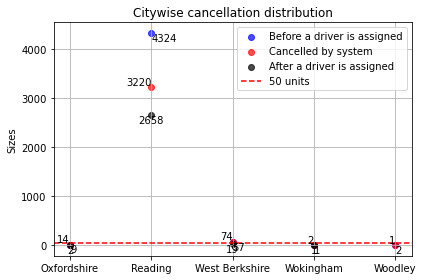

In [971]:
def scattertime(a, b, c,d):
    a= {key: round(value, 2) for key, value in a.items()}
    b= {key: round(value, 2) for key, value in b.items()}
    c= {key: round(value, 2) for key, value in c.items()}
    
    labels_a = list(a.keys())
    sizes_a = list(a.values())
    
    labels_c = list(c.keys())
    sizes_c = list(c.values())
    
    labels_b = list(b.keys())
    sizes_b = list(b.values())

    #plt.figure(figsize=(10, 6))
    
    # Scatter plot for the first dictionary
    plt.scatter(labels_a, sizes_a,  color='blue', alpha=0.7, label='Before a driver is assigned')
    #plt.plot(labels_a, sizes_a,  color='blue', alpha=0.7, linestyle='-', marker='o')  # Adjust linestyle and marker as needed

    # Scatter plot for the second dictionary
    plt.scatter(labels_c, sizes_c,  color='red', alpha=0.7, label='Cancelled by system')
    #plt.plot(labels_c, sizes_c,  color='red', alpha=0.7, linestyle='-', marker='o')  # Adjust linestyle and marker as needed
    
    plt.scatter(labels_b, sizes_b,  color='black', alpha=0.7, label='After a driver is assigned')
    #plt.plot(labels_b, sizes_b,  color='black', alpha=0.7, linestyle='-', marker='o')  # Adjust linestyle and marker as needed
    for label, size in zip(labels_a, sizes_a):
        plt.text(label, size, str(size),ha='left', va='top',position=(label,size+5))
    for label, size in zip(labels_b, sizes_b):
        plt.text(label, size, str(size),ha='center', va='top',position=(label,size-0.5))
    for label, size in zip(labels_c, sizes_c):
        plt.text(label, size, str(size),ha='right', va='bottom',position=(label,size+1.5))

    plt.axhline(y=d, color='red', linestyle='--', label=f'50 units')
    plt.ylabel('Sizes')
    plt.title('Citywise cancellation distribution')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

scattertime(city_n,city_y,city_system,50)

Based on the chart above we can see that there are unusually large number of cancellations in Reading (town/city) area. 

In [962]:
area_y=dfYes[dfYes['town']=='Reading'].groupby(['Area'])['Area'].count().to_dict()
area_n=dfNo[dfNo['town']=='Reading'].groupby(['Area'])['Area'].count().to_dict()
area_system=dfSystemNew[dfSystemNew['town']=='Reading'].groupby(['Area'])['Area'].count().to_dict()

In [963]:
reading_y=dfYes[dfYes['town']=='Reading'].groupby(['Area'])['Area'].count().sort_values(ascending=False).head().to_dict()
reading_n=dfNo[dfNo['town']=='Reading'].groupby(['Area'])['Area'].count().sort_values(ascending=False).head()
reading_s=dfSystemNew[dfSystemNew['town']=='Reading'].groupby(['Area'])['Area'].count().sort_values(ascending=False).head()

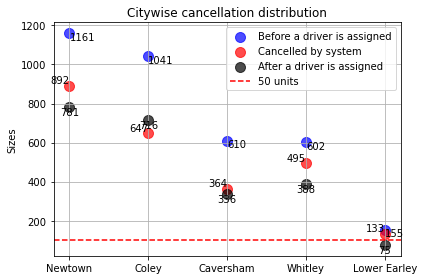

In [964]:
scattertime(reading_n,reading_y,reading_s,100)

Newton and Coley areas have unusually high cancellations.

In [965]:
print(dfYes[(dfYes['Area']=='Newtown')|(dfYes['Area']=='Coley')|(dfYes['Area']=='Whitley')|(dfYes['Area']=='Caversham')].groupby(['Area'])['eta_min'].mean())
print("\nAverage ETA:",dfYes['eta_min'].mean())

Area
Caversham    6.523810
Coley        6.958101
Newtown      7.500640
Whitley      7.079897
Name: eta_min, dtype: float64

Average ETA: 7.217910447761194


In [966]:
print(dfYes[(dfYes['Area']=='Newtown')|(dfYes['Area']=='Coley')|(dfYes['Area']=='Whitley')|(dfYes['Area']=='Caversham')].groupby(['Area'])['cancel_min'].mean())
print("\nAverage Cancellation Time:",dfYes['cancel_min'].mean())

Area
Caversham    3.517857
Coley        3.344972
Newtown      3.546735
Whitley      3.466495
Name: cancel_min, dtype: float64

Average Cancellation Time: 3.6055970149253733


There are no noticeable differences in the ETA and cancellation times with the average values. This points to nature of traffic in that region. We do not have more information like the reason for cancellation. 



In [967]:
value_counts_order_gk = offer['order_gk'].value_counts().value_counts()

# Creating a DataFrame with 'value_counts' as a single column
offers = pd.DataFrame(value_counts_order_gk.reset_index())
offers.columns = ['value counts', 'occurrences']

(offers)

,value counts,occurrences
0,1,25774
1,3,20850
2,4,13661
3,2,12587
4,6,7608
5,5,5735
6,7,5556
7,9,3438
8,8,2758


In [968]:
# Calculate the counts of occurrences for each 'order_gk'
order_gk_counts = offer['order_gk'].value_counts()

# Filter the DataFrame based on 'order_gk' counts equal to 9
for i in range(1,10):
    print("Towns/Cities where orders are offered",i,"times (Driver assigned):")
    result = dfYes['order_gk'][dfYes['order_gk'].isin(order_gk_counts[order_gk_counts == i].index)].unique()
    print(dfYes['town'][dfYes['order_gk'].isin(result)].value_counts())
    print("\nCount of Areas with where orders are offered",i,"times:",len(order['Area'][order['order_gk'].isin(result)].unique()),"\n",)
    print("Towns/Cities where orders are offered",i,"times, (Driver unassigned):")
    result = dfNo['order_gk'][dfNo['order_gk'].isin(order_gk_counts[order_gk_counts == i].index)].unique()
    print(dfNo['town'][dfNo['order_gk'].isin(result)].value_counts())
    print("\nCount of Areas with where orders are offered",i,"times:",len(order['Area'][order['order_gk'].isin(result)].unique()),"\n",)
    print("Towns/Cities where orders are offered",i,"times, (Cancelled by system):")
    result = dfSystemNew['order_gk'][dfSystemNew['order_gk'].isin(order_gk_counts[order_gk_counts == i].index)].unique()
    print(dfSystemNew['town'][dfSystemNew['order_gk'].isin(result)].value_counts())
    print("\nCount of Areas with where orders are offered",i,"times:",len(order['Area'][order['order_gk'].isin(result)].unique()),"\n",)
    

Towns/Cities where orders are offered 1 times (Driver assigned):
Reading           598
West Berkshire     11
Wokingham           1
Oxfordshire         1
Name: town, dtype: int64

Count of Areas with where orders are offered 1 times: 24 

Towns/Cities where orders are offered 1 times, (Driver unassigned):
Reading           640
West Berkshire     15
Oxfordshire         4
Wokingham           1
Name: town, dtype: int64

Count of Areas with where orders are offered 1 times: 26 

Towns/Cities where orders are offered 1 times, (Cancelled by system):
Reading           106
West Berkshire     10
Oxfordshire         3
Name: town, dtype: int64

Count of Areas with where orders are offered 1 times: 22 

Towns/Cities where orders are offered 2 times (Driver assigned):
Reading           226
West Berkshire      4
Name: town, dtype: int64

Count of Areas with where orders are offered 2 times: 18 

Towns/Cities where orders are offered 2 times, (Driver unassigned):
Reading           427
West Berkshire  

Except for certain outliers, Reading is the area where orders are offered multiple times. 

This points to the result from earlier analysis where Reading had a significantly greater number of cancellations. This could be potentially due to lack of demand or other reasons yet to be identified.

All deliverables are delievered and further analysis is conducted. The project can currently be stopped. The main goal of this project is to take a deep dive into Data Analytics and Data Engineering using Statistical Analysis, ETL steps and developing pipelines.

Before we stop, we will save the cleaned dataframes for future reference.

In [969]:
dfYes.to_csv('/Users/luppada/Documents/Projects/data/Gett/Assigned.csv',index=False)
dfNo.to_csv('/Users/luppada/Documents/Projects/data/Gett/Unassigned.csv',index=False)
dfSystemNew.to_csv('/Users/luppada/Documents/Projects/data/Gett/Cancelled.csv',index=False)


## Lessons learned:
   
* Needs better nomemnclature.
* Statistical analysis can be used to identify the emerging trends and outliers.
* Creating functions is better than writing code every time there is a need to call similar functions.
* Plan and create pipelines and functions such that they are aplicable universally.
   